# CFPB Analysis

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score

## 1. Load Data and Some EDA

In [2]:
# Load the data
df = pd.read_csv('shared/complaints_25Nov21.csv')

# Perform basic data exploration
df.head()  # Display the first few rows of the dataset


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,NaN,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",NaN,NaN,NaN,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",NaN,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",NaN,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,NaN,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,NaN,NaN,JPMORGAN CHASE & CO.,VA,22406,Servicemember,NaN,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,NaN,NaN,Referral,2013-05-31,Closed with explanation,Yes,No,418647


In [3]:
df.info()  # Get information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207260 entries, 0 to 207259
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 207260 non-null  object
 1   Product                       207260 non-null  object
 2   Sub-product                   164245 non-null  object
 3   Issue                         207260 non-null  object
 4   Sub-issue                     10347 non-null   object
 5   Consumer complaint narrative  29391 non-null   object
 6   Company public response       58458 non-null   object
 7   Company                       207260 non-null  object
 8   State                         205066 non-null  object
 9   ZIP code                      197974 non-null  object
 10  Tags                          28265 non-null   object
 11  Consumer consent provided?    51313 non-null   object
 12  Submitted via                 207260 non-null  object
 13 

Text(0, 0.5, 'Product')

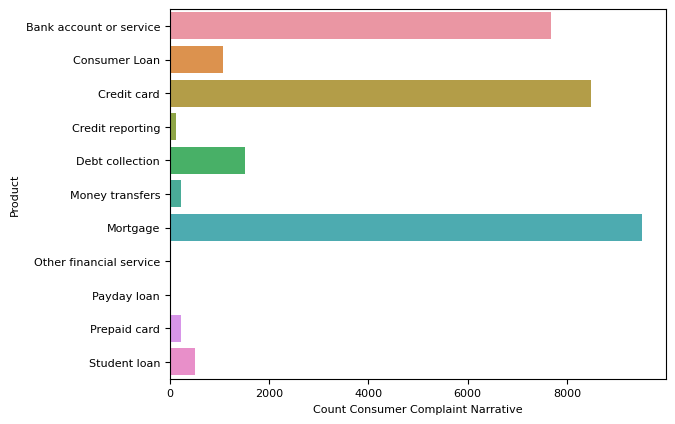

In [4]:
# Visualize the data to compare the complaints base on products
data = df[df['Consumer complaint narrative'].isnull()==False]
product_distribution = data.groupby('Product').count().reset_index()
plt.rcParams.update({'font.size':8})
sns.barplot(x=product_distribution['Consumer complaint narrative'], y=product_distribution['Product'])
plt.xlabel('Count Consumer Complaint Narrative')
plt.ylabel('Product')

In [5]:
df['Date received'] = pd.to_datetime(df['Date received'])
# Get the year that the complaint took place as a separate column
df['Year'] = df['Date received'].apply(lambda date: date.year)

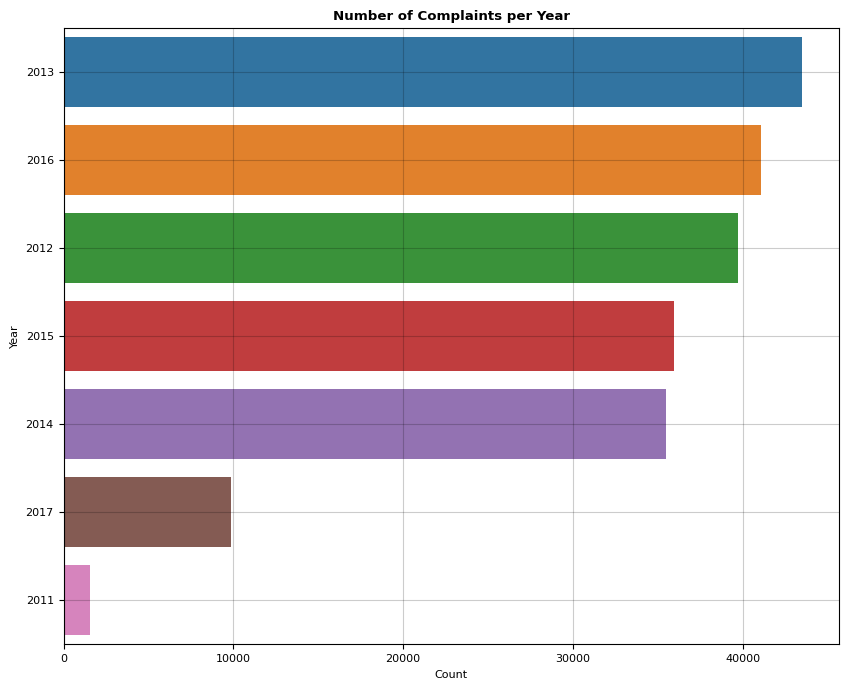

In [6]:
# Vizualize the data to compare base on Year
hue = None
figsize=(10,8)
plt.figure(figsize=figsize)
sns.countplot(y=df['Year'], hue=hue,order=df['Year'].value_counts().index)
plt.xlabel('Count')
plt.ylabel('Year')
plt.title(f'Number of Complaints per Year', fontweight="bold")
plt.grid(True, alpha=0.2, color='black')
plt.show()

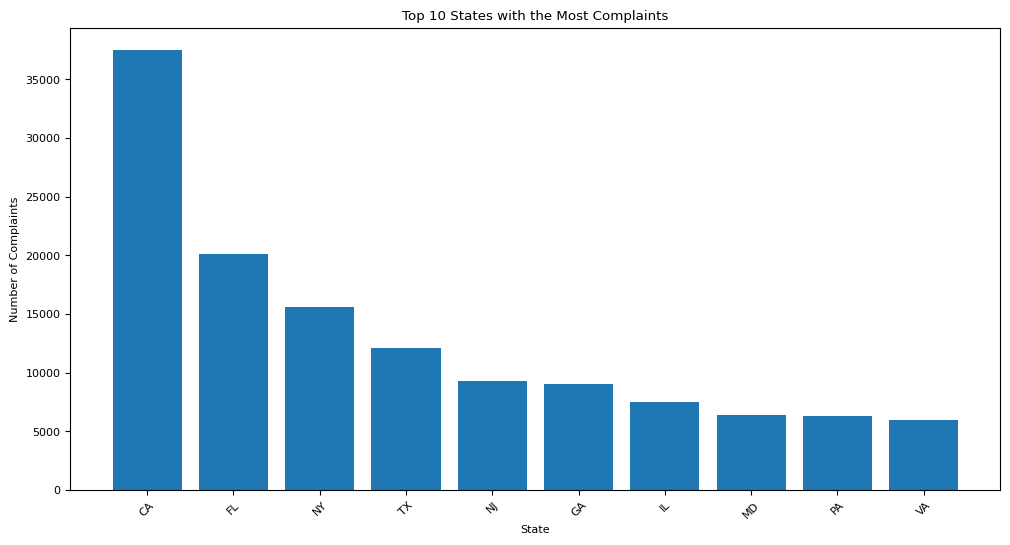

In [7]:
# Get the needed columns
state_complaints = df['State'].value_counts().reset_index()
state_complaints.columns = ['State', 'Complaints']

# Sort the states by the number of complaints in descending order
state_complaints = state_complaints.sort_values(by='Complaints', ascending=False)

# Plot the top N states with the most complaints
N = 10  
top_states = state_complaints.head(N)

plt.figure(figsize=(12, 6))
plt.bar(top_states['State'], top_states['Complaints'])
plt.title(f'Top {N} States with the Most Complaints')
plt.xlabel('State')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()


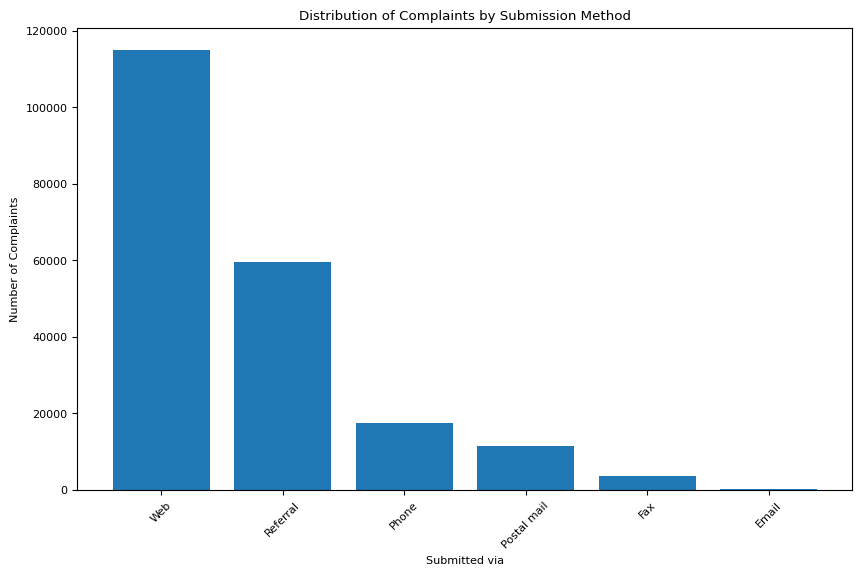

In [8]:
# Get needed columns
submitted_via_counts = df['Submitted via'].value_counts().reset_index()
submitted_via_counts.columns = ['Submitted via', 'Complaints']

plt.figure(figsize=(10, 6))
plt.bar(submitted_via_counts['Submitted via'], submitted_via_counts['Complaints'])
plt.title('Distribution of Complaints by Submission Method')
plt.xlabel('Submitted via')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=45)
plt.show()


## 2. Set X (predictor) and y (predicted) variables. 
## 3. Convert y in between 0 and 1

In [9]:
df = df.fillna("unknown")

In [10]:
# Display the first few rows of the dataset 
# to make sure NA has change to unknown
df.head() 

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Year
0,2016-10-26,Money transfers,International money transfer,Other transaction issues,unknown,"To whom it concerns, I would like to file a fo...",Company has responded to the consumer and the ...,"CITIBANK, N.A.",unknown,unknown,unknown,Consent provided,Web,2016-10-29,Closed with explanation,Yes,No,2180490,2016
1,2015-03-27,Bank account or service,Other bank product/service,"Account opening, closing, or management",unknown,My name is XXXX XXXX XXXX and huband name is X...,Company chooses not to provide a public response,"CITIBANK, N.A.",PA,151XX,Older American,Consent provided,Web,2015-03-27,Closed with explanation,Yes,No,1305453,2015
2,2015-04-20,Bank account or service,Other bank product/service,"Making/receiving payments, sending money",unknown,XXXX 2015 : I called to make a payment on XXXX...,Company chooses not to provide a public response,U.S. BANCORP,PA,152XX,unknown,Consent provided,Web,2015-04-22,Closed with monetary relief,Yes,No,1337613,2015
3,2013-04-29,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",unknown,unknown,unknown,JPMORGAN CHASE & CO.,VA,22406,Servicemember,unknown,Phone,2013-04-30,Closed with explanation,Yes,Yes,393900,2013
4,2013-05-29,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",unknown,unknown,unknown,"BANK OF AMERICA, NATIONAL ASSOCIATION",GA,30044,unknown,unknown,Referral,2013-05-31,Closed with explanation,Yes,No,418647,2013


In [11]:
# Selecting the predictors as specified
predictor_columns = ['Product', 'Sub-product', 'Issue', 'State', 'Tags', 'Submitted via', 'Company response to consumer', 'Timely response?']
X = df[predictor_columns]

# Convert X to numeric
X = pd.get_dummies(X, predictor_columns)

# Convert 'Consumer disputed?' to binary labels
le = LabelEncoder()
y = le.fit_transform(df['Consumer disputed?'])



## 4. Split your data into a test and train set.

In [12]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)


## 5. Check what proportion of complaints in your training dataset are disputed.

In [13]:
# Q1
# Calculate the proportion of consumers who raised a dispute in the test set 
proportion_disputed_test = sum(y_test) / len(y_test)
proportion_disputed_test

0.21586413200810575

In [14]:
# Q2
# Calculate the proportion of consumers who raised a dispute in the train set
proportion_disputed = sum(y_train) / len(y_train)
proportion_disputed

0.21684719675769565

In [15]:
# Set a number (e.g., 0.3) to determine if random undersampling is needed
sample = 0.3

if proportion_disputed < sample:
    # Apply random undersampling to balance the dataset
    undersampler = RandomUnderSampler(random_state=123)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X, y)
    print("Proportion of disputed complaints after undersampling:", sum(y_train_resampled) / len(y_train_resampled))
else:
    X_train_resampled, y_train_resampled = X_train, y_train
    print("No undersampling applied, as the proportion of disputed complaints is sufficient.")


Proportion of disputed complaints after undersampling: 0.5


## 6. Train a predictive model

In [16]:
# Fit Model
model_xgb = XGBClassifier(random_state=123)
model_xgb.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=123, ...)

## 7. Evaluate the model on the test set, and create the classification report and confusion matrix.

In [17]:
# Q3
# Predict the model and get evaluation
y_pred = model_xgb.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.53      0.66     32504
           1       0.28      0.65      0.39      8948

    accuracy                           0.56     41452
   macro avg       0.56      0.59      0.52     41452
weighted avg       0.73      0.56      0.60     41452

[[17353 15151]
 [ 3104  5844]]


In [18]:
# Calculate recall for the 'Consumer disputed?' = 'Yes' category
recall_disputed_test = recall_score(y_test, y_pred)  
recall_disputed_test

0.6531068395172106

## 8. Calculate the total cost if not using a model.

In [19]:
# Q4
# Calculate the cost base on no model
disputed = y_test.sum()
non_disputed = len(y_test) - disputed

cost = disputed * 600 + non_disputed * 100 
print("Total cost (base case):", cost)

Total cost (base case): 8619200


## 9. Calculate the total cost in dollars based on the model results

In [20]:
# Q5
# Calculate the confusion matrix for the model's predictions
conf_matrix = confusion_matrix(y_test, y_pred)

# Define the cost structure
cost_per_non_disputed = 100  # Cost for non-disputed complaint
cost_per_disputed = 600     # Cost for disputed complaint
cost_per_extra_diligence = 190  # Cost for performing extra diligence

# Initialize variables to keep track of total costs
total_cost_model_results = 0  # Total cost based on model results

# Extract values from the confusion matrix
true_negatives, false_positives, false_negatives, true_positives = conf_matrix.ravel()

# Calculate the total cost based on the model results
total_cost_model_results = (true_negatives * cost_per_non_disputed) + \
                           (false_negatives * cost_per_disputed) + \
                           (false_positives * cost_per_extra_diligence) + (true_positives * cost_per_extra_diligence)

# Print the total cost based on model results
print("Total cost based on model results: $", total_cost_model_results)


Total cost based on model results: $ 7586750


## 10. Change the classification threshold on the model

In [23]:
# Q6 and Q7
# Predict the probabilities for the classes that are positive
y_probs = model_xgb.predict_proba(X_test)[:, 1]

# Define the cost function based on the problem statement
def calculate_cost(threshold, y_true, y_probs):
    y_pred = (y_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()    
    return (tp * (100 + 90)) + (fp * (100 + 90)) + (tn * 100) + (fn * 600)

# Initialize the minimum cost to a large number and the optimal threshold to None
min_cost = float('inf')
optimal_threshold = None

# Iterate over a range of thresholds to find the one that minimizes the total cost
for threshold in np.linspace(0, 1, 101):  # 101 points between 0 and 1, inclusive
    cost = calculate_cost(threshold, y_test, y_probs)
    if cost < min_cost:
        min_cost = cost
        optimal_threshold = threshold

# Output the optimal threshold and the corresponding cost
print(f"Optimal threshold: {optimal_threshold}")
print(f"Total cost at optimal threshold: ${min_cost}")

Optimal threshold: 0.46
Total cost at optimal threshold: $7491540
